# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum-gamma-limit"

nb_devices_for_the_run = 20

# Handling non-iid data

Following columns has missing values: [21, 22, 23, 30, 45, 46, 47, 56]
The columns with empty values have been removed.
This columns are empty: [40, 41, 42, 43, 44]
Now, there is 65 dimensions.
Head of the dataset (columns has not been re-indexed).
   state         2         3         4    5         6    7         8    9  \
0     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   
1     -1  0.920167  0.817883 -0.646473 -1.0  0.000000  0.0  0.000000  0.0   
2      1  0.868397  0.178202  0.150828 -1.0  0.000000  0.0  0.000000  0.0   
3     -1  0.000000  0.000000  0.000000  0.0  1.577894  0.0 -0.369792 -1.0   
4     -1  0.000000  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0   

         10  ...   70        71        72        73        74        75   76  \
0  0.876238  ... -1.0 -0.036906 -0.000724  0.000000  0.000000  0.000000  0.0   
1  0.401383  ... -1.0 -0.999927 -0.012102  0.920167  0.817883 -0.646473 -1.0   
2  0.773496  ...  1.0  0.908824  0.550843  0.868

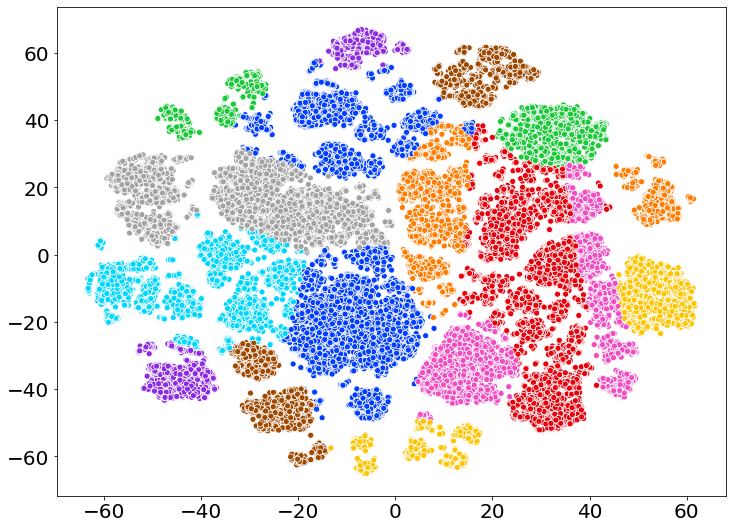

In [2]:
%%time
nb_cluster = nb_devices_for_the_run
X, Y, dim_notebook = prepare_quantum(nb_cluster, iid=False)

In [3]:
from src.utils.data.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Number of points on device 0 : 5913
Number of points on device 1 : 1011
Number of points on device 2 : 1088
Number of points on device 3 : 1582
Number of points on device 4 : 1293
Number of points on device 5 : 1638
Number of points on device 6 : 2393
Number of points on device 7 : 1964
Number of points on device 8 : 1231
Number of points on device 9 : 3492
Number of points on device 10 : 3821
Number of points on device 11 : 3433
Number of points on device 12 : 2038
Number of points on device 13 : 5509
Number of points on device 14 : 871
Number of points on device 15 : 1998
Number of points on device 16 : 2622
Number of points on device 17 : 4744
Number of points on device 18 : 2006
Number of points on device 19 : 1353


In [4]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y_r:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.39624556062912225
ratio of state 1 on this device:  0.9188921859545005
ratio of state 1 on this device:  0.4898897058823529
ratio of state 1 on this device:  0.0012642225031605564
ratio of state 1 on this device:  0.24748646558391338
ratio of state 1 on this device:  0.48473748473748474
ratio of state 1 on this device:  0.4220643543669035
ratio of state 1 on this device:  0.540224032586558
ratio of state 1 on this device:  0.45410235580828595
ratio of state 1 on this device:  0.5100229095074456
ratio of state 1 on this device:  0.6459042135566606
ratio of state 1 on this device:  0.42004078065831635
ratio of state 1 on this device:  0.6226692836113837
ratio of state 1 on this device:  0.5859502632056635
ratio of state 1 on this device:  0.08495981630309989
ratio of state 1 on this device:  0.3948948948948949
ratio of state 1 on this device:  0.986651411

In [5]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X_r, Y_r, nb_devices_for_the_run)

In [6]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=10000, 
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    2000 | 5.2482e-01
    4000 | 5.2482e-01
    6000 | 5.2482e-01
    8000 | 5.2482e-01
Gradient Descent: execution time=126.234 seconds
Final loss : 0.52482

CPU times: user 8min 16s, sys: 4.51 s, total: 8min 20s
Wall time: 2min 6s


# Impact of step size

In [7]:
scenario="step"

step_formula = [(lambda it, L, omega, N: 40 / (2*L)),
                (lambda it, L, omega, N: 20 / (2*L)),
                (lambda it, L, omega, N: 5 / L),
                (lambda it, L, omega, N: 2 / L),
                (lambda it, L, omega, N: 1 / L),
                (lambda it, L, omega, N: 1 / (2*L)),
                (lambda it, L, omega, N: 1 / (4*L)),
                (lambda it, L, omega, N: 1 / (8*L)),
                (lambda it, L, omega, N: 1 / (16*L)),
                (lambda it, L, omega, N: 1 / (32*L))
                ]

label_step_formula = ["N/L", 
                      "N/2L",
                "5/L",
                "2/L",
                "$L^{-1}$",
                "$2L^{-1}$",
                "$4L^{-1}$",
                "$8L^{-1}$",
                "$16L^{-1}$",
                "$32L^{-1}$"
                ]

## Random Sparsification

In [8]:
compression = RandomSparsification(12, dim_notebook, biased=False)
omega_c = "$\omega_C = " + str(compression.omega_c)[:4] + "$"
print("omega C : {0}".format(compression.omega_c))

In [23]:
%%time
batch_size = 400

run_for_different_scenarios(cost_models, ARTEMIS_LIKE_ALGO[1:], step_formula, label_step_formula, filename,
                            batch_size, stochastic=False, scenario=scenario, compression=compression, nb_epoch=100)

100%|██████████| 6/6 [04:45<00:00, 47.60s/it]


quantum-gamma-limit-step
CPU times: user 15min 58s, sys: 13.2 s, total: 16min 11s
Wall time: 4min 46s


### Without averaging

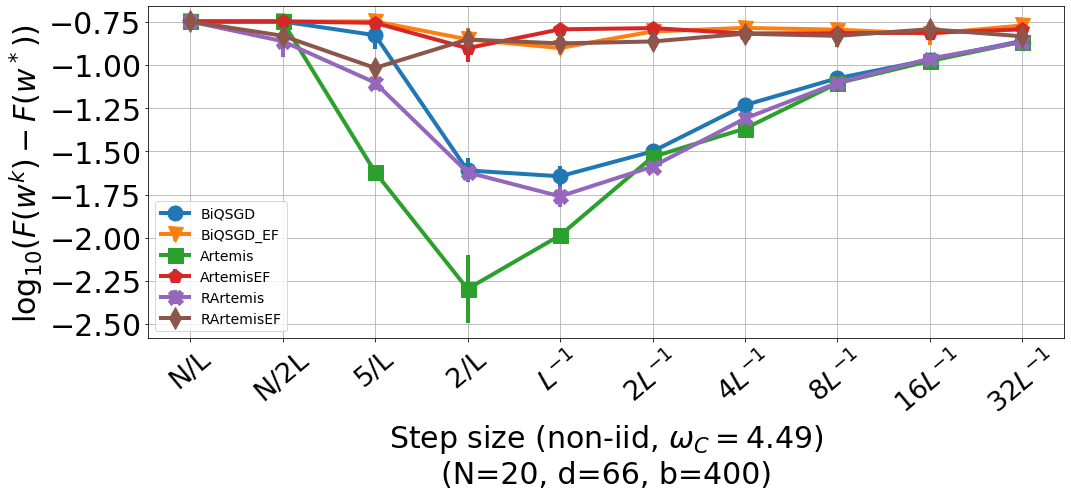

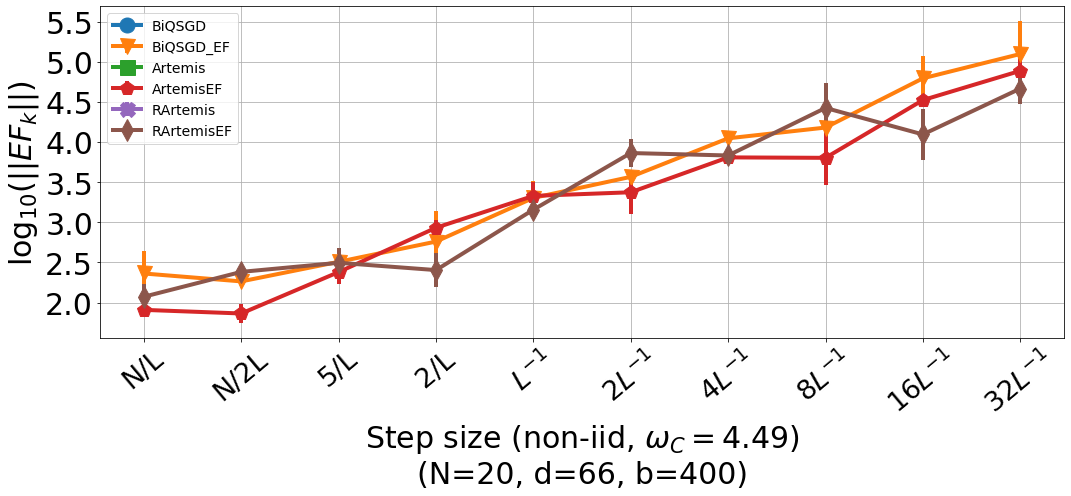

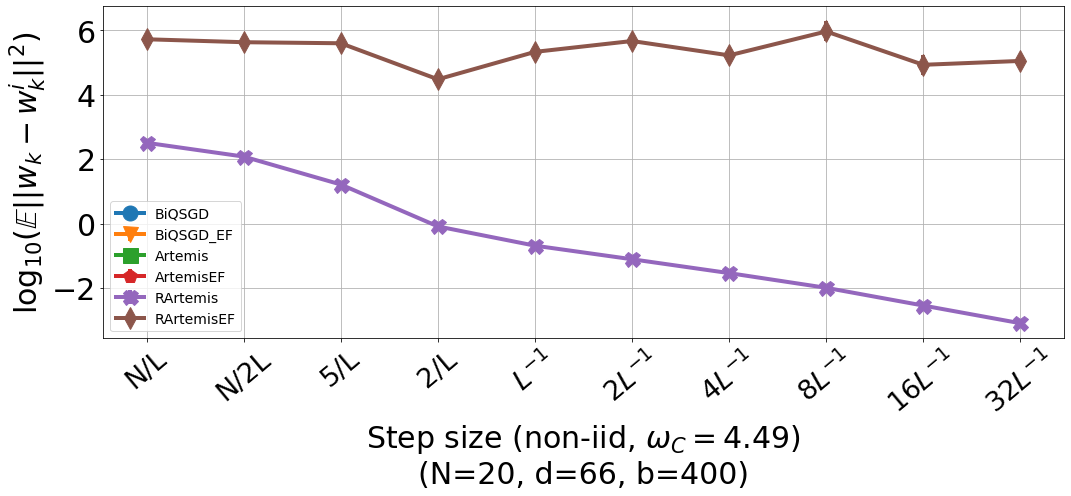

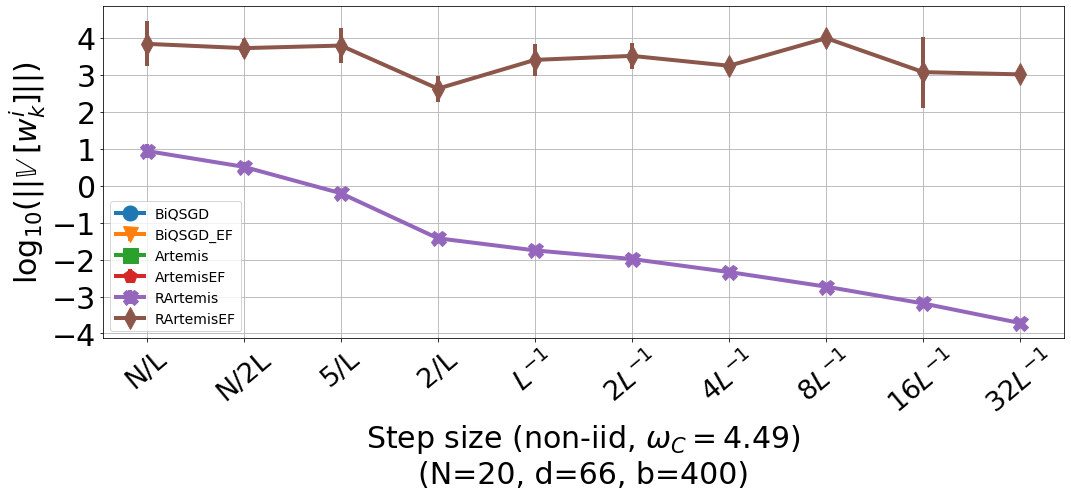

In [27]:
batch_size = 400

obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula)

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_error_feedback_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="ef")

plot_error_dist(res.get_distance_to_model(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_distance_to_model_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_dist")

plot_error_dist(res.get_var_models(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_var_models_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_var")


### With averaging

In [ ]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size (Avg, non-iid), {0})".format(omega_c), one_on_two_points=False,
                xlabels=label_step_formula) 


## TopK Sparsification

In [38]:
compression = TopKSparsification(5, dim_notebook)
omega_c = "$\omega_C = " + str(compression.omega_c)[:4] + "$"
print("omega C : {0}".format(compression.omega_c))

omega C : 0.9242424242424242


In [29]:
%%time
batch_size = 400

run_for_different_scenarios(cost_models, ARTEMIS_LIKE_ALGO, step_formula, label_step_formula, filename,
                            batch_size, stochastic=False, scenario=scenario, compression=compression)

100%|██████████| 7/7 [12:44<00:00, 109.24s/it]


quantum-gamma-limit-step
CPU times: user 49min 18s, sys: 27.8 s, total: 49min 46s
Wall time: 12min 46s


### Without averaging

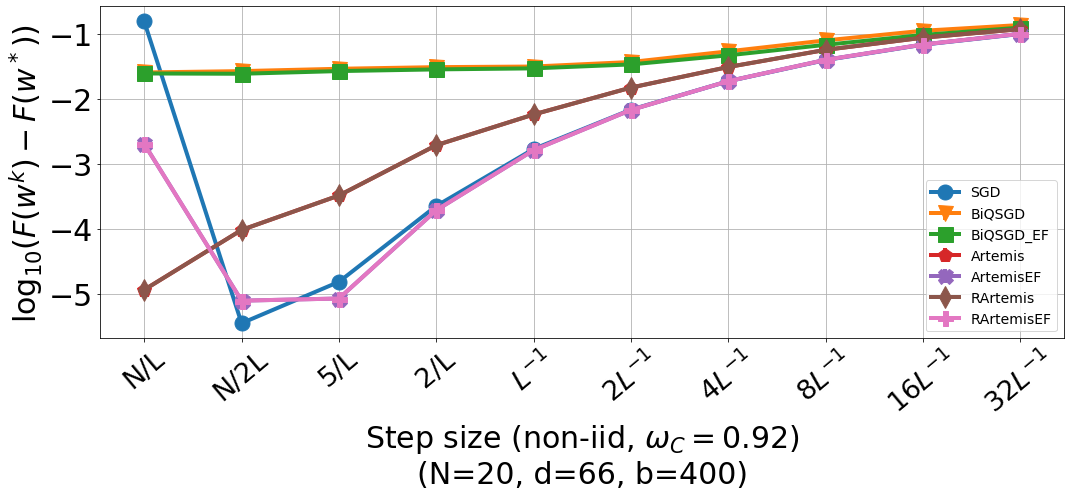

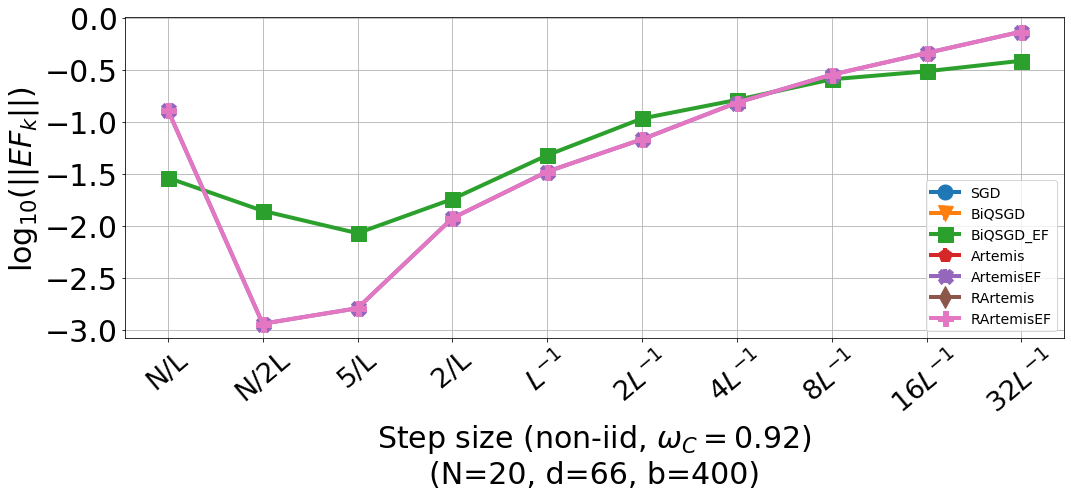

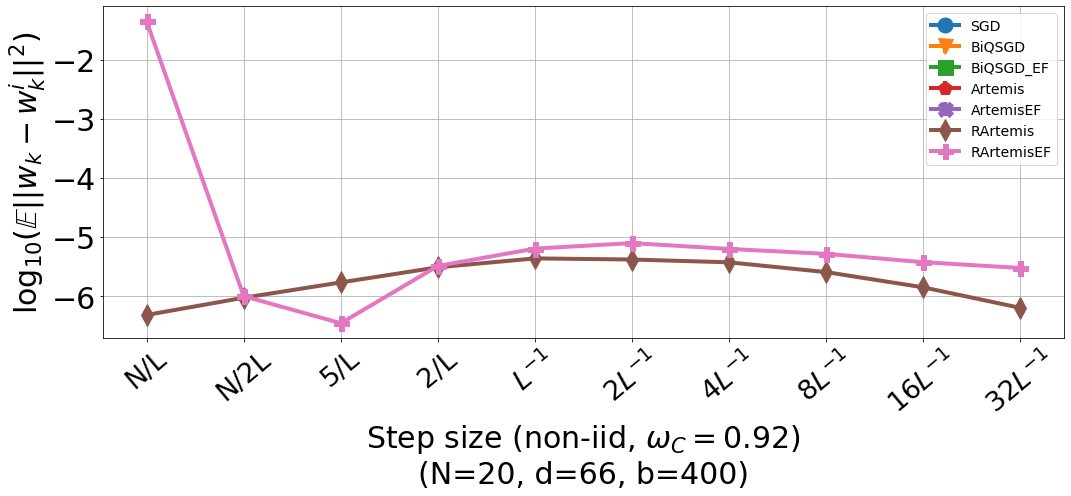

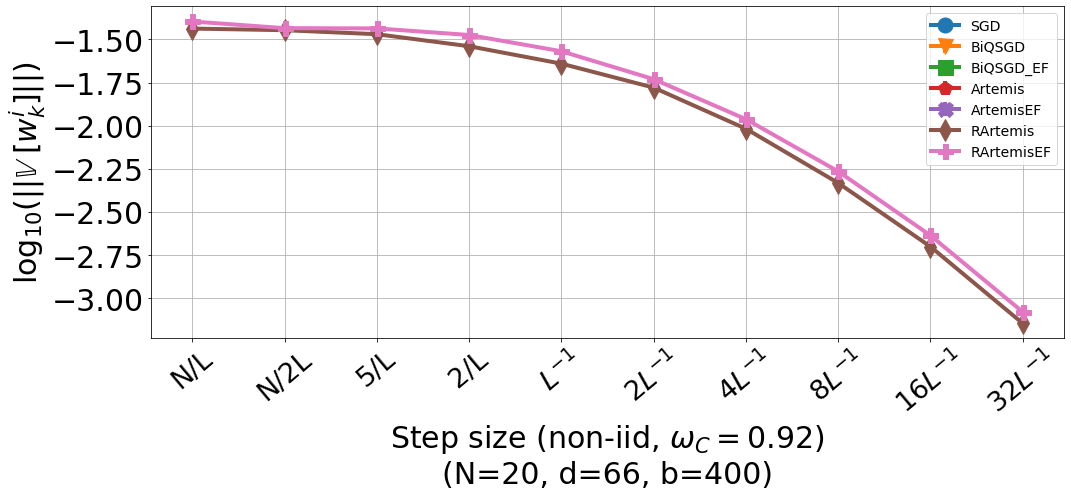

In [39]:
batch_size = 400

obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula)

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_error_feedback_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="ef")

plot_error_dist(res.get_distance_to_model(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_distance_to_model_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_dist")

plot_error_dist(res.get_var_models(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_var_models_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_step_formula, ylegends="rand_var")

### With averaging

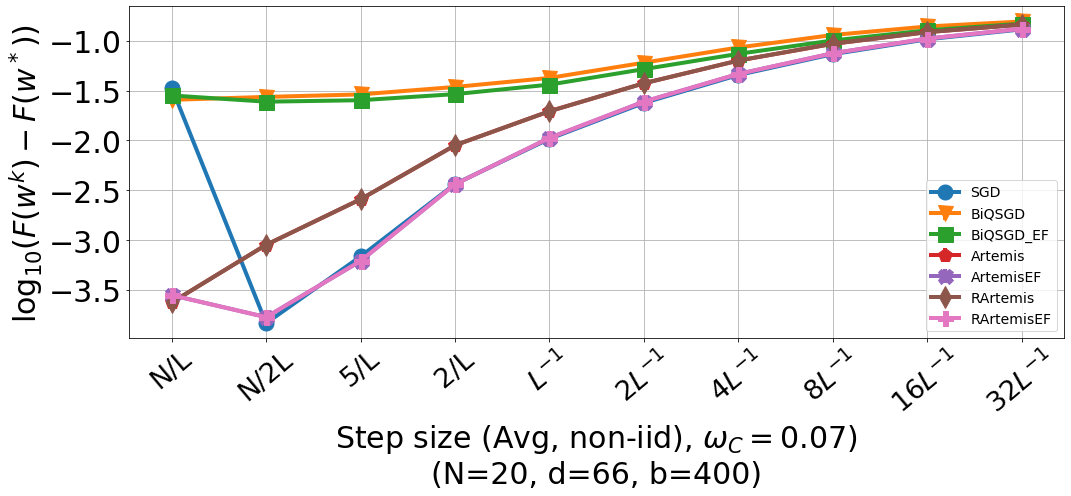

In [37]:
batch_size = 400
scenario = "step"
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Step size (Avg, non-iid), {0})".format(omega_c), one_on_two_points=False,
                xlabels=label_step_formula) 


### Display loss for each algorithm

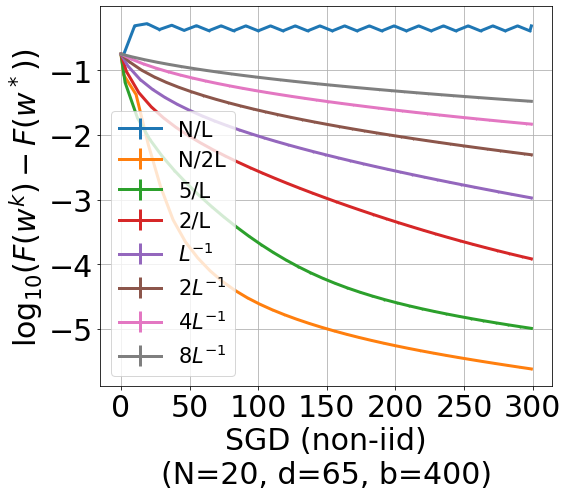

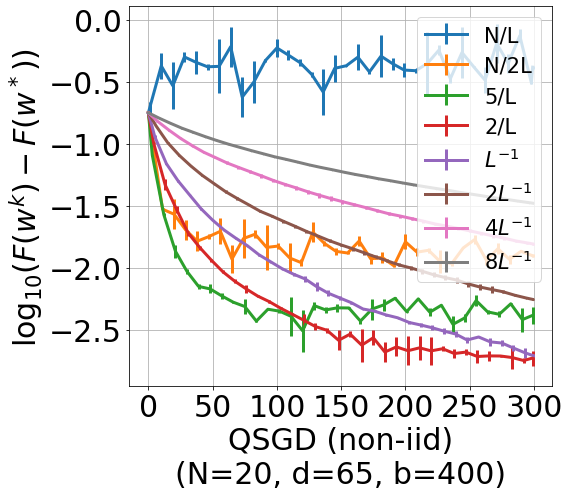

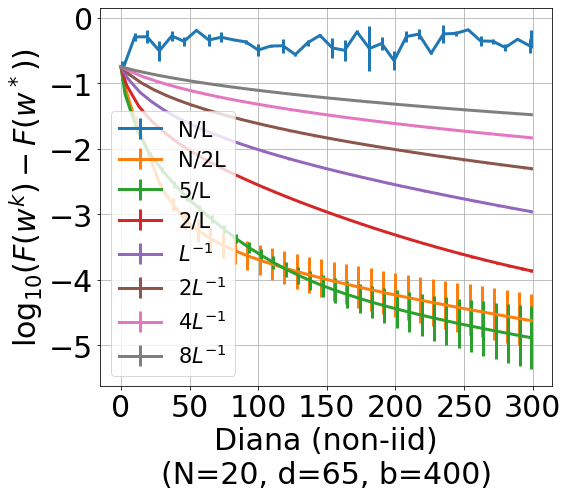

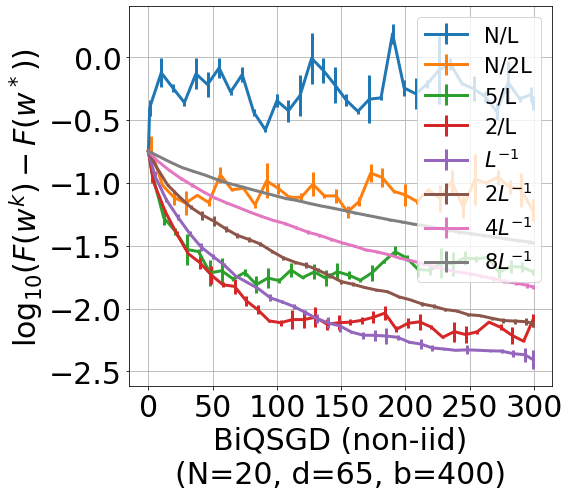

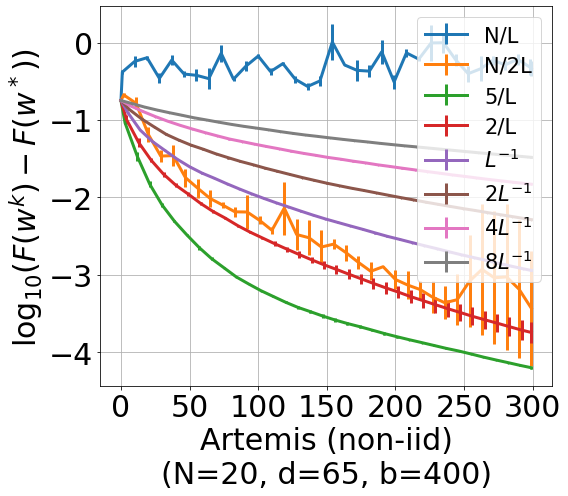

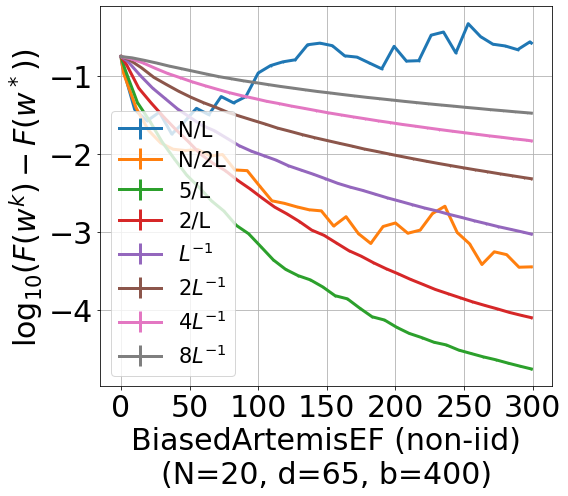

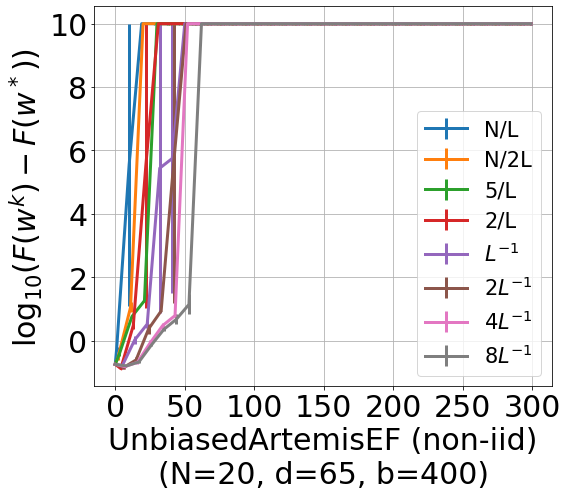

In [24]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-descent_by_algo_and_{1}".format(filename, scenario))
for algo_name, algo in res.items():
    plot_error_dist(algo.get_loss(obj), algo.names, algo.nb_devices_for_the_run, dim_notebook, 
                    batch_size=batch_size, all_error=algo.get_std(obj), x_legend="{0} (non-iid)".format(algo_name)) 


### Display algo with its optimal step size

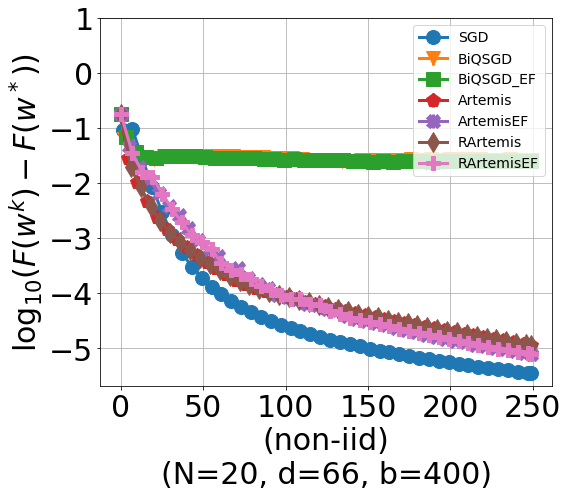

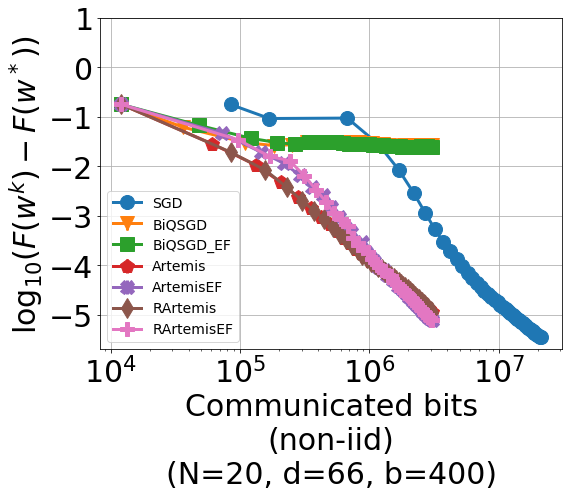

In [65]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-optimal_{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj), batch_size=batch_size,
                x_legend="(non-iid)", ylim=True) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj), ylim=True) 

# Impact of compression

In [40]:
level_spars = 5
level_quantiz = 2

scenario="compression"

def deux_L(it, L, omega, N): return 2 / L

values_compression = [SQuantization(0, dim_notebook),
                      TopKSparsification(level_spars, dim_notebook),
                      TopKSparsification(2*level_spars, dim_notebook),
                      RandomSparsification(level_spars, dim_notebook, biased=True),
                      RandomSparsification(2*level_spars, dim_notebook, biased=True),
                      RandomSparsification(level_spars, dim_notebook, biased=False),
                      RandomSparsification(2*level_spars, dim_notebook, biased=False),
                      RandomSparsification(34, dim_notebook, biased=False),
                      SQuantization(level_quantiz, dim_notebook),
                      SQuantization(2*level_quantiz, dim_notebook)
                     ]

label_compression = ["SGD"] + [value.get_name() + "\n" + str(value.omega_c)[:4] for value in values_compression[1:]]

print(label_compression)

['SGD', 'Topk\n0.92', 'Topk\n0.84', 'RdkBsd\n0.92', 'RdkBsd\n0.84', 'Rdk\n12.2', 'Rdk\n5.6', 'Rdk\n0.94', 'Qtzd\n4.06', 'Qtzd\n2.03']


In [32]:
%%time
batch_size = 400

run_for_different_scenarios(cost_models, ARTEMIS_LIKE_ALGO[1:], values_compression, label_compression, filename, 
                            batch_size, stochastic=False, step_formula=deux_L, scenario=scenario)

100%|██████████| 6/6 [11:29<00:00, 115.00s/it]


quantum-gamma-limit-compression
CPU times: user 44min 42s, sys: 26.9 s, total: 45min 9s
Wall time: 11min 31s


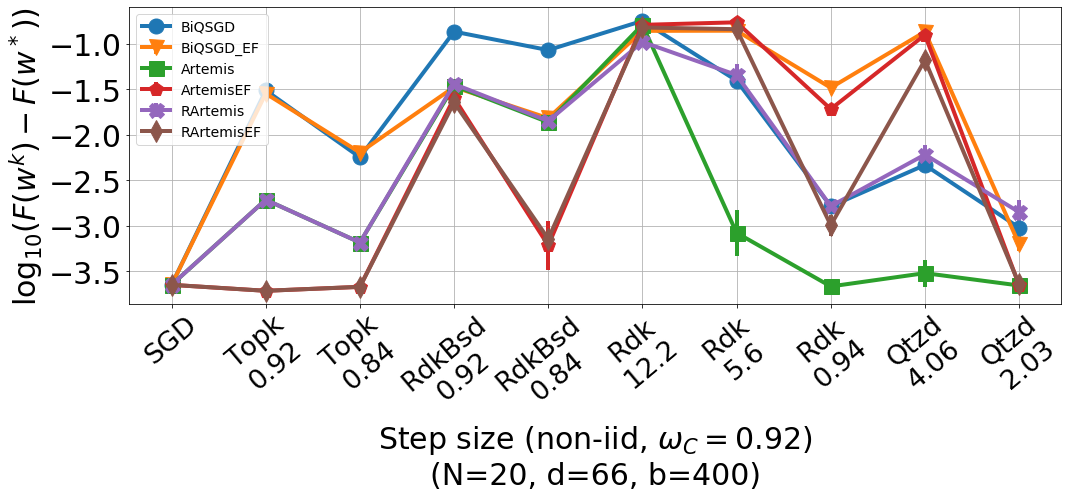

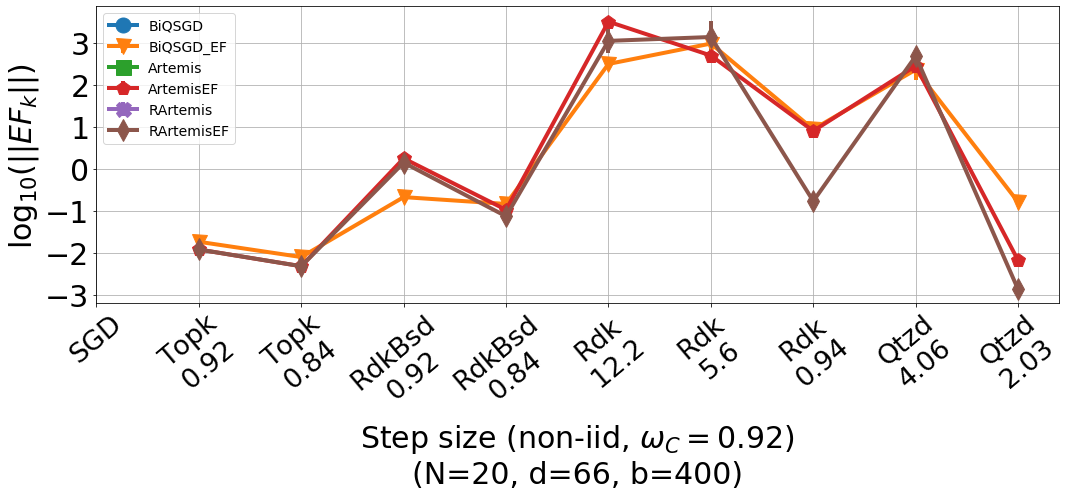

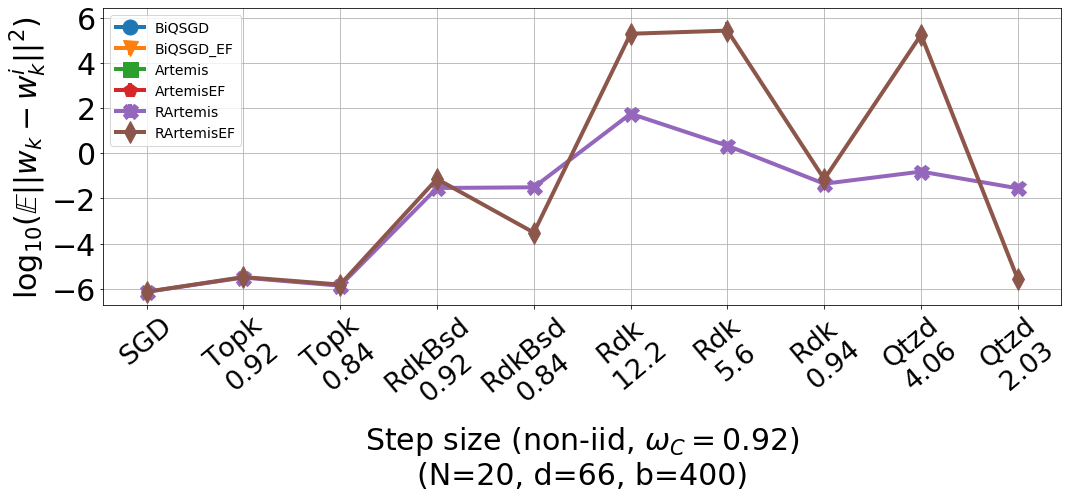

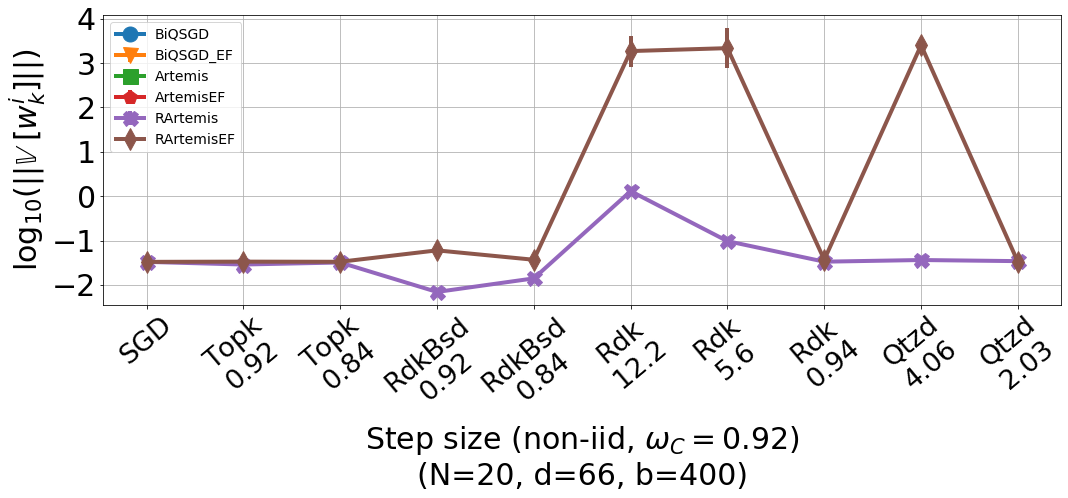

In [41]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression)

plot_error_dist(res.get_error_feedback(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_error_feedback_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="ef")

plot_error_dist(res.get_distance_to_model(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_distance_to_model_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="rand_dist")

plot_error_dist(res.get_var_models(), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_var_models_std(), x_legend="Step size (non-iid, {0})".format(omega_c), 
                one_on_two_points=False, xlabels=label_compression, ylegends="rand_var")

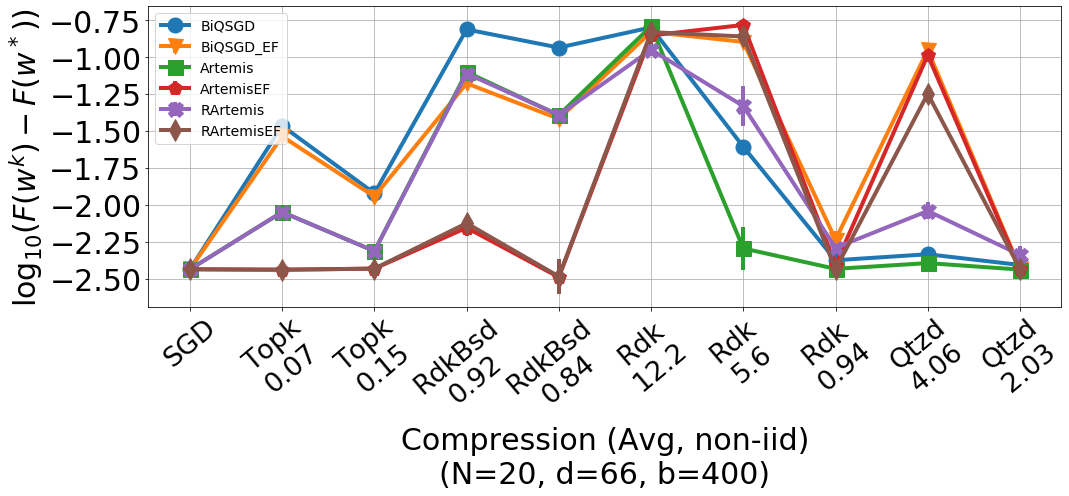

In [35]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-{1}".format(filename, scenario))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                batch_size=batch_size, all_error=res.get_std(obj, averaged=True), 
                x_legend="Compression (Avg, non-iid)", one_on_two_points=False, xlabels=label_compression) 